In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tqdm import tqdm_notebook
import os

import data_processor
import importlib

In [3]:
import pickle

In [4]:
data_processor = importlib.reload(data_processor)

## INITIAL PROCESSING 

In [5]:
path_DL = "../data_all_CDR/DL_{}.txt"

In [6]:
path_DV = "../data_all_CDR/Dv_PB_{}.txt"

In [7]:
t4_a = pd.read_table(path_DV.format(4))
t8_a = pd.read_table(path_DV.format(8))

In [8]:
t4 = pd.read_table(path_DV.format(4), usecols=["count", "CDR3aa", "V"])
t8 = pd.read_table(path_DV.format(8), usecols=["count", "CDR3aa", "V"])

In [19]:
CDR1_to_seq = dict(pd.read_table("../data_all_CDR/TRBV_aaCDR1_func.tsv", names = ['gene', 'seq']).values)
CDR2_to_seq= dict(pd.read_table("../data_all_CDR/TRBV_aaCDR2_func.tsv", names = ['gene', 'seq']).values)

In [10]:
not_presented = sorted([x for x in set([x for x in t4["V"].values if x not in CDR2_to_seq.keys()])])

In [11]:
CDR1_add = ["GHDS", "WNHNN", "SGHND", "FGHNF", "KGHSY", "KAHSY", "KGHTF", 
           "LGHNA", "GTSNPN", "SGHSS", "SGHTS", "MNHEY", "MNHEY", "SGHVT", "_____"]
CDR2_add = ["YNCKEF", "SYGVQD", "FCSWTL", 'FRS_SI', "FQNENV", "FQNEEL", "FQNEQV", 
           "YSNKEP", "SVGIG", "YANELR", "YYEKEE", "SVGEGT", "SVAAAL", "SQSDAQ", "______"]



In [21]:
for i, gene in enumerate(not_presented):
    CDR1_to_seq[gene] = CDR1_add[i]
    CDR2_to_seq[gene] = CDR2_add[i]

In [146]:
pickle.dump(CDR1_to_seq, open("../CDR1_dict", 'wb'))
pickle.dump(CDR2_to_seq, open("../CDR2_dict", 'wb'))

In [17]:
len(pickle.load(open("../CDR1_dict", 'rb')))

58

In [22]:
len(CDR2_to_seq)

58

In [23]:
mask8 = t8["count"] > 1
mask4 = t4["count"] > 1

In [24]:
t4 = t4.loc[mask4]
t4_a = t4_a.loc[mask4]
t8 = t8.loc[mask8]
t8_a = t8_a.loc[mask8]

print(t4.shape, t8.shape)


(72638, 3) (31954, 3)


In [25]:
def add_CDR_1_2(table, CDR1_dict, CDR2_dict, ref_column = "V"):
    table["CDR1"] = [CDR1_dict[x] for x in table[ref_column]]
    table["CDR2"] = [CDR2_dict[x] for x in table[ref_column]]
    return table[["CDR1", "CDR2", "CDR3aa"]]

In [26]:
t4_fin = add_CDR_1_2(t4, CDR1_to_seq, CDR2_to_seq)
t8_fin = add_CDR_1_2(t8, CDR1_to_seq, CDR2_to_seq)

In [27]:
t8_fin.head()

,CDR1,CDR2,CDR3aa
0,SGHRS,YFSETQ,CASSQDDNSPLHF
1,KGHSH,LQKENI,CASSPPQGGAYNEQFF
2,SGHDN,FVKESK,CASSPHRQRAFF
3,KGHDR,SFDVKD,CATSDLDSSYNEQFF
4,SQVTM,ANQGSEA,CSVEGGTIYEQYF


## TO NUMS

In [28]:
acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

In [29]:
l_to_n = dict(zip(sorted(acids), np.arange(1,len(acids) + 1)))

In [30]:
l_to_n["b"] = 21
l_to_n["e"] = 22
l_to_n["_"] = 0

In [31]:
def shape_seq(seq, l, mode='middle'):
    if mode not in ['middle', 'beginning']:
        raise ValueError("Mode should be one of middle, beginning")
    if mode == 'middle':
        if len(seq) > l:
            return seq[int((len(seq) - l)/ 2) : int((len(seq) + l) / 2)]
        else:
            seq2 = "____________________" + seq + "____________________"
            return seq2[int((len(seq2) - l)/ 2) : int((len(seq2) + l) / 2)]
    else:
        if len(seq) > l:
            return seq[:l]
        else:
            return seq + '_' * (l - len(seq))

In [32]:
def CDR_to_num_array(seq, dictionary, array_len):
    seq_arr = np.zeros(array_len, dtype = np.int8)
    
    seq_arr[0] = dictionary["b"]
    for i, symbol in enumerate(seq):
        seq_arr[i + 1] = dictionary[symbol]
    seq_arr[i + 2] = dictionary["e"]
    
    return seq_arr

In [33]:
CDR_to_num_array(shape_seq("ACDF", 4), l_to_n, 12)

array([21,  1,  2,  3,  5, 22,  0,  0,  0,  0,  0,  0], dtype=int8)

In [39]:
max_len = max([len(x) for x in t_f]) + 2
max_len

74

In [52]:
def transform_row(table, cols, l_to_n, mode = 'middle'):
    
    if type(cols) != list:
        cols = [cols]
    print(cols)
    for col in cols:
        max_len = min(max([len(x) for x in table[col]]) + 2, 15)
        print(max_len)
        transformed_vals = [CDR_to_num_array(shape_seq(x, max_len), l_to_n, max_len + 2) for x in table[col]]
    
        table.loc[:, col] = transformed_vals
    #else:
    #    table[col] = [CDR_to_num_array(shape_seq(x, len(x)), l_to_n, max_len) for x in table[col]]
    return table

In [53]:
t4_fin = add_CDR_1_2(t4, CDR1_to_seq, CDR2_to_seq)
t8_fin = add_CDR_1_2(t8, CDR1_to_seq, CDR2_to_seq)

In [54]:
t4_n = transform_row(t4_fin, ["CDR1","CDR2","CDR3aa"], l_to_n)
t8_n = transform_row(t8_fin, ["CDR1","CDR2","CDR3aa"], l_to_n)

['CDR1', 'CDR2', 'CDR3aa']
8


/home/anton/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


9
15
['CDR1', 'CDR2', 'CDR3aa']
8
9
15


In [55]:
t4_n["CDR3aa"][0]

array([21,  2, 16,  1, 13,  3, 15, 10, 16,  6, 12, 17,  4,  1,  5,  5, 22],
      dtype=int8)

In [57]:
t4_n

,CDR1,CDR2,CDR3aa
0,"[21, 0, 3, 5, 14, 1, 17, 17, 0, 22]","[21, 0, 16, 12, 4, 6, 16, 9, 1, 0, 22]","[21, 2, 16, 1, 13, 3, 15, 10, 16, 6, 12, 17, 4..."
1,"[21, 0, 0, 10, 6, 7, 3, 17, 0, 22]","[21, 0, 0, 20, 12, 12, 9, 4, 10, 0, 22]","[21, 2, 1, 16, 16, 13, 18, 16, 6, 15, 12, 17, ..."
2,"[21, 0, 0, 16, 14, 18, 17, 11, 0, 22]","[21, 0, 1, 12, 14, 6, 16, 4, 1, 0, 22]","[21, 0, 2, 16, 16, 18, 10, 16, 6, 16, 20, 12, ..."
3,"[21, 0, 0, 16, 6, 7, 12, 16, 0, 22]","[21, 0, 0, 5, 12, 12, 12, 18, 13, 0, 22]","[21, 0, 2, 1, 16, 8, 16, 6, 3, 13, 16, 6, 4, 1..."
4,"[21, 0, 0, 16, 6, 7, 3, 20, 0, 22]","[21, 0, 0, 5, 12, 12, 12, 18, 13, 0, 22]","[21, 2, 1, 16, 16, 18, 14, 6, 13, 8, 6, 16, 1,..."
5,"[21, 0, 0, 16, 14, 18, 17, 11, 0, 22]","[21, 0, 1, 12, 14, 6, 16, 4, 1, 0, 22]","[21, 0, 0, 2, 16, 17, 6, 15, 6, 13, 3, 17, 14,..."
6,"[21, 0, 0, 16, 6, 7, 12, 16, 0, 22]","[21, 0, 0, 5, 12, 12, 12, 18, 13, 0, 22]","[21, 0, 2, 1, 16, 16, 19, 3, 13, 15, 16, 4, 14..."
7,"[21, 0, 0, 16, 6, 7, 17, 1, 0, 22]","[21, 0, 0, 5, 14, 6, 12, 16, 1, 0, 22]","[21, 0, 2, 1, 16, 16, 10, 15, 19, 10, 14, 4, 1..."
8,"[21, 0, 0, 16, 6, 7, 12, 16, 0, 22]","[21, 0, 0, 5, 12, 12, 12, 18, 13, 0, 22]","[21, 0, 2, 1, 16, 16, 16, 12, 13, 10, 17, 13, ..."
9,"[21, 0, 0, 16, 6, 7, 3, 20, 0, 22]","[21, 0, 0, 5, 12, 12, 12, 18, 13, 0, 22]","[21, 2, 1, 16, 16, 15, 14, 1, 13, 15, 6, 17, 6..."


In [58]:
t4_n.to_csv("../data/Dv_PB/t4.csv")
t8_n.to_csv("../data/Dv_PB/t8.csv")

In [78]:
X_0 = np.vstack((np.vstack(t4_n.values[:,0]), np.vstack(t8_n.values[:,0])))
X_1 = np.vstack((np.vstack(t4_n.values[:,1]), np.vstack(t8_n.values[:,1])))
X_2 = np.vstack((np.vstack(t4_n.values[:,2]), np.vstack(t8_n.values[:,2])))

In [83]:
y = np.array([0] * t4_n.shape[0] + [1] * t8_n.shape[0])

In [87]:

np.save("../data/Dv_PB/X_0", X_0)
np.save("../data/Dv_PB/X_1", X_1) 
np.save("../data/Dv_PB/X_2", X_2)
np.save("../data/Dv_PB/y", y)

In [88]:
len(l_to_n)

23

In [52]:
genes_4 = dict(t4_a["V"].value_counts() / t4_a["V"].value_counts().sum())
genes_8 = dict(t8_a["V"].value_counts() /t8_a["V"].value_counts().sum())

In [58]:
genes = sorted(list((set(genes_4.keys()).intersection(set(genes_8.keys())))))

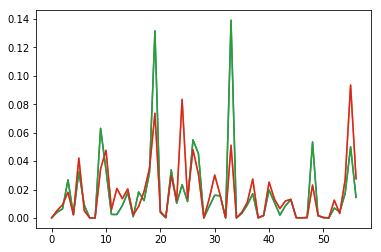

In [61]:
plt.plot([genes_4[x] for x in genes])
plt.plot([genes_8[x] for x in genes])
plt.show()

In [44]:
t4_a.head()
t8_a.head()

,count,frequency,CDR3nt,CDR3aa,V,D,J,Vend,Dstart,Dend,Jstart
0,47632,0.123259,TGCGCCAGCAGTCAGGACGATAATTCACCCCTCCACTTT,CASSQDDNSPLHF,TRBV5-1,NaN,TRBJ1-6,11,-1,-1,19
1,12540,0.032450,TGTGCCAGCTCACCACCGCAGGGTGGGGCCTACAATGAGCAGTTCTTC,CASSPPQGGAYNEQFF,TRBV18,TRBD1,TRBJ2-1,17,18,23,28
2,10728,0.027761,TGTGCCAGCAGCCCCCACCGCCAACGGGCTTTCTTT,CASSPHRQRAFF,TRBV14,NaN,TRBJ1-1,13,-1,-1,27
3,7925,0.020508,TGTGCCACCAGTGATTTGGACAGCTCCTACAATGAGCAGTTCTTC,CATSDLDSSYNEQFF,TRBV24-1,NaN,TRBJ2-1,18,-1,-1,21
4,7850,0.020314,TGCAGCGTTGAAGGCGGCACTATCTACGAGCAGTACTTC,CSVEGGTIYEQYF,TRBV29-1,TRBD2,TRBJ2-7,13,14,22,23


In [12]:
t4.shape

(344148, 2)

In [13]:
intersection = (set(t4["CDR3nt"].values).intersection(t8["CDR3nt"].values))

In [54]:
def to_seq_arrays(table_4, table_8, target_column):
    intersection = (set(table_4[target_column].values).intersection(table_8[target_column].values))
    
    table_4_filtred = [x for x in table_4[target_column].values if not x in intersection]
    table_8_filtred = [x for x in table_8[target_column].values if not x in intersection]
    
    table_4_intersection = np.concatenate([x.reshape(1, -1) for x in table_4.values if x[1] in intersection])
    table_8_intersection = np.concatenate([x.reshape(1, -1) for x in table_8.values if x[1] in intersection])


    print(table_4_intersection.shape)
    for el in tqdm_notebook(intersection):
        #print(table_4_intersection[:,2])
        #print(np.where(table_4_intersection[:,2] == el))
        #print(table_4_intersection[np.where(table_4_intersection[:,2] == el)[0]])
        i4 = np.array(np.where(table_4_intersection[:,1] == el)[0])
        i8 = np.array(np.where(table_8_intersection[:,1] == el)[0])

        if table_4_intersection[i4,0].sum() > table_8_intersection[i8,0].sum():
            table_4_filtred.append(el)
        else:
            table_8_filtred.append(el)
            
    return table_4_filtred, table_8_filtred

In [55]:
t4_f, t8_f = to_seq_arrays(t4, t8, "CDR3aa")

(12333, 2)


A Jupyter Widget

342111

In [87]:
set(t4_f).intersection(set(t8_f))

set()

In [89]:
np.save("../data/LY/unique_CDR3_4", np.array(t4_f))
np.save("../data/LY/unique_CDR3_8", np.array(t8_f))

In [56]:
y_f = np.array([0] * len(t4_f) + [1] * len(t8_f))
t_f = t4_f + t8_f

In [40]:
RNN_data_as_list = [CDR_to_num_array(x, l_to_n, max_len) for x in tqdm_notebook(t_f)]

A Jupyter Widget

In [41]:
RNN_data = np.concatenate([x.reshape(1,-1) for x in RNN_data_as_list])

In [42]:
np.save("../data/Kal_all_CDR/RNN_data_filtred", RNN_data)
np.save("../data/Kal_all_CDR//RNN_data_filtred_y", np.array(y_f))

In [43]:
len(y_f)

504191

In [131]:
RNN_data.shape

(622947, 26)

In [47]:
import pickle

In [48]:
pickle.dump(l_to_n, open("../data/Kal_all_CDR/l_to_n", "wb"))

In [45]:
len((t_f))

504191

## Try bigrams

In [6]:
from nltk import bigrams, ngrams

In [7]:
calc_ngrams = lambda y, n : [''.join(x) for x in ngrams(y, n)]

In [11]:
def all_ngrams(X, n):
    all_ngrams = dict()
    for x in tqdm_notebook(X):
        for ngramm in calc_ngrams(x,n):
            if ngramm in all_ngrams.keys():
                all_ngrams[ngramm] += 1
            else:
                all_ngrams[ngramm] = 1
                
    return all_ngrams

In [ ]:
def prepare_ngrams_table()

In [32]:
s4_3 = all_ngrams(t4["aaSeqCDR3"].values[:], 3)
s8_3 = all_ngrams(t8["aaSeqCDR3"].values[:], 3)

A Jupyter Widget

A Jupyter Widget

In [66]:
counter = 0
for trig in s8_3.keys():
    if not trig in intersection_3:
        counter += s8_3[trig]
print("c", counter)

c 164


In [35]:
intersection_3 = set(s4_3.keys()).intersection(set(s8_3.keys()))

In [37]:
intersection_with_counts = pd.DataFrame(columns = [4,8], index=sorted(list(intersection_3)))

In [39]:
for ngramm in tqdm_notebook(intersection_3):
    intersection_with_counts.loc[ngramm, 4] = s4_3[ngramm]
    intersection_with_counts.loc[ngramm, 8] = s8_3[ngramm]

intersection_with_counts[4] = intersection_with_counts[4] / intersection_with_counts[4].sum()
intersection_with_counts[8] = intersection_with_counts[8] / intersection_with_counts[8].sum()

A Jupyter Widget

In [71]:
intersection_with_counts[4] = intersection_with_counts[4] / intersection_with_counts[4].sum()
intersection_with_counts[8] = intersection_with_counts[8] / intersection_with_counts[8].sum()

In [73]:
def plot_bar_part(table, start, end):
    plt.bar(np.arange(end-start), intersection_with_counts[start:end][4], alpha = 0.5)
    plt.bar(np.arange(end-start), intersection_with_counts[start:end][8],  alpha = 0.5)
    plt.show()

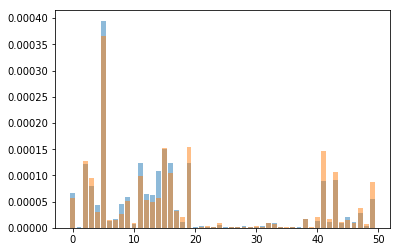

In [75]:
plot_bar_part(intersection_with_counts, 0, 50)

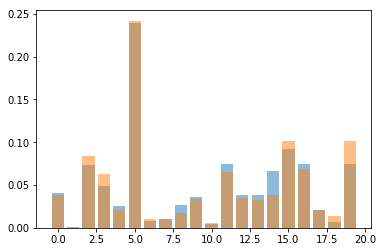

In [49]:
plt.bar(np.arange(20), intersection_with_counts[:20][4] / sum(intersection_with_counts[:20][4]), alpha = 0.5)
plt.bar(np.arange(20), intersection_with_counts[:20][8] / sum(intersection_with_counts[:20][8]),  alpha = 0.5)
plt.show()

In [110]:
s4_1 = all_ngrams(t4["aaSeqCDR3"].values, 1)
s8_1 = all_ngrams(t8["aaSeqCDR3"].values, 1)

A Jupyter Widget

A Jupyter Widget

In [112]:
s1 = set(s4_1.keys()).union(set(s8_1.keys()))

In [113]:
d1 = dict(zip(sorted(list(s1)), range(len(s1))))

In [114]:
d1

{'A': 0,
 'C': 1,
 'D': 2,
 'E': 3,
 'F': 4,
 'G': 5,
 'H': 6,
 'I': 7,
 'K': 8,
 'L': 9,
 'M': 10,
 'N': 11,
 'P': 12,
 'Q': 13,
 'R': 14,
 'S': 15,
 'T': 16,
 'V': 17,
 'W': 18,
 'Y': 19}

## Emb

In [33]:
kidera = pd.DataFrame(list(map(lambda x: x.split(","), "A,-1.56,-1.67,-0.97,-0.27,-0.93,-0.78,-0.2,-0.08,0.21,-0.48;R,0.22,1.27,1.37,1.87,-1.7,0.46,0.92,-0.39,0.23,0.93;N,1.14,-0.07,-0.12,0.81,0.18,0.37,-0.09,1.23,1.1,-1.73;D,0.58,-0.22,-1.58,0.81,-0.92,0.15,-1.52,0.47,0.76,0.7;C,0.12,-0.89,0.45,-1.05,-0.71,2.41,1.52,-0.69,1.13,1.1;Q,-0.47,0.24,0.07,1.1,1.1,0.59,0.84,-0.71,-0.03,-2.33;E,-1.45,0.19,-1.61,1.17,-1.31,0.4,0.04,0.38,-0.35,-0.12;G,1.46,-1.96,-0.23,-0.16,0.1,-0.11,1.32,2.36,-1.66,0.46;H,-0.41,0.52,-0.28,0.28,1.61,1.01,-1.85,0.47,1.13,1.63;I,-0.73,-0.16,1.79,-0.77,-0.54,0.03,-0.83,0.51,0.66,-1.78;L,-1.04,0,-0.24,-1.1,-0.55,-2.05,0.96,-0.76,0.45,0.93;K,-0.34,0.82,-0.23,1.7,1.54,-1.62,1.15,-0.08,-0.48,0.6;M,-1.4,0.18,-0.42,-0.73,2,1.52,0.26,0.11,-1.27,0.27;F,-0.21,0.98,-0.36,-1.43,0.22,-0.81,0.67,1.1,1.71,-0.44;P,2.06,-0.33,-1.15,-0.75,0.88,-0.45,0.3,-2.3,0.74,-0.28;S,0.81,-1.08,0.16,0.42,-0.21,-0.43,-1.89,-1.15,-0.97,-0.23;T,0.26,-0.7,1.21,0.63,-0.1,0.21,0.24,-1.15,-0.56,0.19;W,0.3,2.1,-0.72,-1.57,-1.16,0.57,-0.48,-0.4,-2.3,-0.6;Y,1.38,1.48,0.8,-0.56,0,-0.68,-0.31,1.03,-0.05,0.53;V,-0.74,-0.71,2.04,-0.4,0.5,-0.81,-1.07,0.06,-0.46,0.65".split(";"))), index=["A","R","N","D","C","Q","E","G","H","I","L","K","M","F","P","S","T","W","Y","V"], columns=["aminoacid"] + list(map(lambda x: "f"+str(x), range(1,11))))

In [145]:
kidera.to_csv("../data/kidera")

In [117]:
atchley_list = list(map(lambda x: x.split("\t"),open("../kidera-atchley/atchley.txt", encoding='utf-8').read().split("\n")))[:-1]

In [118]:
atchley_list

[['amino.acid', 'f1', 'f2', 'f3', 'f4', 'f5'],
 ['A', '−0.591', '−1.302', '−0.733', '1.570', '−0.146'],
 ['C', '−1.343', '0.465', '−0.862', '−1.020', '−0.255'],
 ['D', '1.050', '0.302', '−3.656', '−0.259', '−3.242'],
 ['E', '1.357', '−1.453', '1.477', '0.113', '−0.837'],
 ['F', '−1.006', '−0.590', '1.891', '−0.397', '0.412'],
 ['G', '−0.384', '1.652', '1.330', '1.045', '2.064'],
 ['H', '0.336', '−0.417', '−1.673', '−1.474', '−0.078'],
 ['I', '−1.239', '−0.547', '2.131', '0.393', '0.816'],
 ['K', '1.831', '−0.561', '0.533', '−0.277', '1.648'],
 ['L', '−1.019', '−0.987', '−1.505', '1.266', '−0.912'],
 ['M', '−0.663', '−1.524', '2.219', '−1.005', '1.212'],
 ['N', '0.945', '0.828', '1.299', '−0.169', '0.933'],
 ['P', '0.189', '2.081', '−1.628', '0.421', '−1.392'],
 ['Q', '0.931', '−0.179', '−3.005', '−0.503', '−1.853'],
 ['R', '1.538', '−0.055', '1.502', '0.440', '2.897'],
 ['S', '−0.228', '1.399', '−4.760', '0.670', '−2.647'],
 ['T', '−0.032', '0.326', '2.213', '0.908', '1.313'],
 ['V', '

In [124]:
bad_float_processor('0.595')

0.595

In [84]:
atchley = pd.DataFrame(data = atchley_list[1:], columns = atchley_list[0])#, index=sorted(["A","R","N","D","C","Q","E","G","H","I","L","K","M","F","P","S","T","W","Y","V"])#, columns=["aminoacid"] + list(map(lambda x: "f"+str(x), range(1,11))))

In [86]:
atchley.head()

,amino.acid,f1,f2,f3,f4,f5
0,A,−0.591,−1.302,−0.733,1.570,−0.146
1,C,−1.343,0.465,−0.862,−1.020,−0.255
2,D,1.050,0.302,−3.656,−0.259,−3.242
3,E,1.357,−1.453,1.477,0.113,−0.837
4,F,−1.006,−0.590,1.891,−0.397,0.412


## Constanter classifiers

In [80]:
plt.hist([len(x) for x  in t4_f])
plt.hist([len(x) for x  in t8_f])
plt.show()

NameError: name 't4_f' is not defined

In [77]:
L = 8
fixed_len4 = [process_seq(x, L) for x  in t4_f]
fixed_len8 = [process_seq(x, L) for x  in t8_f]

In [ ]:
fix

In [60]:
def process_fixed_len(seq, d):
    ans = np.zeros(len(d) * len(seq))
    for i, letter in enumerate(seq):
        if letter in d:
            ans[i * len(d) + d[letter]] = 1
    return ans

In [78]:
one_hot_4 = np.concatenate([process_fixed_len(x, d1).reshape(1,-1) for x in fixed_len4[:]])
one_hot_8 = np.concatenate([process_fixed_len(x, d1).reshape(1,-1) for x in fixed_len8[:]])

In [79]:
one_hot_4.shape

(426968, 160)

In [70]:
y = one_hot_4.shape[0] * [0] + one_hot_8.shape[0] * [1]
one_hot_X = np.vstack((one_hot_4, one_hot_8))

In [71]:
np.save("./LY_one_hot_15", one_hot_X)
np.save("./LY_one_hot_15_y", np.array(y))

In [146]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [8]:
one_hot_X = np.load("./LY_one_hot_15.npy")
y = np.load("./LY_one_hot_15_y.npy")

In [147]:
train_X, test_X, train_y,  test_y = train_test_split(x_14_atch, y_14_atch)
    

In [81]:
lr = LogisticRegression(verbose= 1)
lr.fit(train_X, train_y)

[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=1, warm_start=False)

In [82]:
accuracy_score(test_y, lr.predict(test_X))

0.69119091802205

In [159]:
svm = SVC(class_weight='balanced', probability=True)
svm.fit(train_X, train_y)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [162]:
svm.

<bound method BaseSVC.decision_function of SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)>

In [164]:
pred_y = svm.predict_proba(test_X)

In [161]:
accuracy_score(test_y, pred_y)

0.6008954920118043

In [155]:
mask

False

In [157]:
mask = np.array(test_y) == 1
accuracy_score(np.array(test_y)[mask], pred_y[mask])

0.11648612553791364

In [158]:
mask = np.array(test_y) == 0
accuracy_score(np.array(test_y)[mask], pred_y[mask])

0.9578010065814944

## EMB on chosen len

In [123]:
def bad_float_processor(x):
    if x[0] == '−' : return float('-' + x[1:])
    else: return float(x)

In [126]:
atchley_dict = dict(zip(atchley["amino.acid"].values, [[bad_float_processor(x) for x in y] for y in atchley[atchley.columns[1:]].values]))

In [127]:
atchley_dict["A"]

[-0.591, -1.302, -0.733, 1.57, -0.146]

In [130]:
def to_emb(seq, emb_dict):
    emb_len = len(emb_dict["A"])
    answ = np.zeros(len(seq) * emb_len)
    
    for i, aa in enumerate(seq):
        answ[i * emb_len: (i+1) * emb_len] = emb_dict[aa]
    
    return answ

In [131]:
to_emb(t4_f[0], atchley_dict)

array([-1.343,  0.465, -0.862, -1.02 , -0.255, -0.228,  1.399, -4.76 ,
        0.67 , -2.647, -0.384,  1.652,  1.33 ,  1.045,  2.064, -0.384,
        1.652,  1.33 ,  1.045,  2.064,  1.357, -1.453,  1.477,  0.113,
       -0.837, -0.032,  0.326,  2.213,  0.908,  1.313,  1.831, -0.561,
        0.533, -0.277,  1.648, -0.384,  1.652,  1.33 ,  1.045,  2.064,
       -0.032,  0.326,  2.213,  0.908,  1.313,  0.931, -0.179, -3.005,
       -0.503, -1.853,  0.26 ,  0.83 ,  3.097, -0.838,  1.512, -1.006,
       -0.59 ,  1.891, -0.397,  0.412])

In [138]:
t4_14_atch = [to_emb(x, atchley_dict) for x in t4_f if len(x) == 14]
t8_14_atch = [to_emb(x, atchley_dict) for x in t8_f if len(x) == 14]

In [144]:
y_14_atch = [0] * len(t4_14_atch) + [1] * len(t8_14_atch)
x_14_atch = np.array(t4_14_atch + t8_14_atch)

## CHECK

In [160]:
ly_322 = np.load("../data/322_LY/LY_RNN.npy")

In [161]:
ly = np.load("../data/LY_/RNN_data_filtred.npy")

In [170]:
ly_322[0]

array([21,  2,  1, 16, 16, 14, 13,  6,  6,  3, 12,  4,  9, 10,  5,  5, 22,
        0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int8)

In [171]:
ly[0]

array([21,  2,  1, 16, 16, 14, 13,  6,  6,  3, 12,  4,  9, 10,  5,  5, 22,
        0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int8)